## Free Time-dependent Schrödinger equation

We consider the time-dependent Schrödinger equation for a free particle:

$$
i \partial_t u(x,y,t) = - \Delta u(x,y,t)
$$

with homogeneous Dirichlet boundary conditions:

$$
u(x,y,t) = 0 \quad \text{on } \partial \Omega, t \geq 0
$$

and initial condition:

$$
u(x,y,0) = u_0(x,y)
$$

where

$$
u_0(x,y) = \sin(\pi x) \sin(\pi y)
$$

The exact solution is:

$$
u_{exact}(x,y,t) = \sin(\pi x) \sin(\pi y) e^{-2 i \pi^2 t}
$$

Proof:

In the following, we will assume $\Omega = [0,1]^2$. We take the ansatz:

$$
u(x,y,t) = \phi(x,y) e^{-i \lambda t}
$$

Substituting this into the Schrödinger equation, we get:

$$
i \partial_t \phi(x,y) e^{-i \lambda t} = - \Delta \phi(x,y) e^{-i \lambda t}
$$

which results in:

$$
\lambda \phi(x,y) = - \Delta \phi(x,y)
$$

The eigenfunctions of the Dirichlet Laplacian on the unit square are the sine functions:

$$
\phi_{n,m}(x,y) = \sin(n \pi x) \sin(m \pi y)
$$

where $n,m \in \mathbb{N}$ and $\lambda_{n,m} = \pi^2 (n^2 + m^2)$. From the initial condition, we know that $n = m = 1$.

Therefore, the exact solution is:

$$
u_{exact}(x,y,t) = \sin(\pi x) \sin(\pi y) e^{-2 i \pi^2 t}
$$

## Variational formulation

Take any $v \in H^1_0(\Omega)$, vanishing on the boundary. Multiplying the free time-dependent Schrödinger equation with $\bar{v}$ and integrating over $\Omega$ by parts, we get:

$$
i \int_{\Omega} (\partial_t u(x,y,t)) \bar{v}(x,y,t) = \int_{\Omega} \nabla u(x,y,t) \cdot \nabla \bar{v}(x,y,t).
$$

## Time discretization

Discretizing the time domain $t \in [0,T]$ into $N$ subintervals of length $dt = T/N$, and using an implicit time discretization, we can rewrite the time derivative as:

$$
\partial_t u(x,y,t) \approx \frac{u(x,y,t+dt) - u(x,y,t)}{dt}
$$

Substituting this into the variational formulation, we get:

$$
i \int_{\Omega} \frac{u(x,y,t+dt) - u(x,y,t)}{dt} \bar{v}(x,y) = \int_{\Omega} \nabla u(x,y,t+dt) \cdot \nabla \bar{v}(x,y),
$$

## Sesquilinear form

By rewritting the time-discretized variational formulation as 

$$
i \int_{\Omega} u(x,y,t+dt) \bar{v}(x,y) - dt \int_{\Omega} \nabla u(x,y,t+dt) \cdot \nabla \bar{v}(x,y) = i \int_{\Omega} u(x,y,t) \bar{v}(x,y),
$$

we can identify the sesquilinear form:

$$
a(u,v) = i \int_{\Omega} u(x,y,t+dt) \bar{v}(x,y) - dt \int_{\Omega} \nabla u(x,y,t+dt) \cdot \nabla \bar{v}(x,y)
$$

and the linear form:

$$
L(v) = i \int_{\Omega} u(x,y,t) \bar{v}(x,y).
$$

In [265]:
import dolfinx
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
import ufl
from petsc4py import PETSc
from dolfinx.fem.petsc import assemble_vector, assemble_matrix
import pyvista

In [266]:
# Verify that PETSc is using complex numbers
print(f"PETSc ScalarType: {PETSc.ScalarType}")
assert np.dtype(PETSc.ScalarType).kind == 'c', "PETSc must be compiled with complex numbers"

PETSc ScalarType: <class 'numpy.complex128'>


In [267]:
# Time parameters
T = 1.0
N = 100
dt = T/N

In [268]:
# Mesh parameters
nx, ny = 50, 50  # Mesh resolution

# Create mesh
mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, nx, ny)

# Define spatial coordinate
x = ufl.SpatialCoordinate(mesh)

In [269]:
# Define function spaces
V = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))

# Define trial and test functions
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Define functions for current and previous time steps
u_t = dolfinx.fem.Function(V, dtype=np.complex128)  # Previous time step
u_t1 = dolfinx.fem.Function(V, dtype=np.complex128)  # Current time step

# Define initial condition
def initial_condition(x):
    return np.sin(np.pi * x[0]) * np.sin(np.pi * x[1])

# Set initial condition (t=0)
u_t.interpolate(initial_condition)

# Define exact solution
def exact_solution(x, t):
    return np.sin(np.pi * x[0]) * np.sin(np.pi * x[1]) * np.exp(-2j * np.pi**2 * t)

In [270]:
# Define sesquilinear form
a = 1j * ufl.inner(u, v) * ufl.dx - dt * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx

# Linear form
L = 1j * ufl.inner(u_t, v) * ufl.dx

In [271]:
# Get boundary facets and dofs
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
boundary_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
boundary_dofs = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim-1, boundary_facets)

# Define boundary conditions
u_D = dolfinx.fem.Function(V, dtype=np.complex128)
u_D.x.array[:] = 0.0
bc = dolfinx.fem.dirichletbc(u_D, boundary_dofs)

In [272]:
# Define linear problem
problem = dolfinx.fem.petsc.LinearProblem(a, L, bcs=[bc])

In [273]:
times = []
l2_errors = []

# Time stepping loop
print("Starting time stepping...")
for n in range(N):
    # Current time
    t = (n + 1) * dt
    times.append(t)

    # Solve for current time step
    u_t1 = problem.solve()

    # Compute exact solution at current time
    u_exact = dolfinx.fem.Function(V, dtype=np.complex128)
    u_exact.interpolate(lambda x: exact_solution(x, t))

    # Compute and store L2 error
    error_form = ufl.inner(u_t1 - u_exact, u_t1 - u_exact) * ufl.dx
    error_local = dolfinx.fem.assemble_scalar(dolfinx.fem.form(error_form))
    error_global = np.sqrt(mesh.comm.allreduce(error_local, op=MPI.SUM))
    l2_errors.append(abs(error_global))

    # Update solution for next time step
    u_t.x.array[:] = u_t1.x.array[:]

    # Print progress
    if (n + 1) % 10 == 0:
        print(f"Time step {n+1}/{N}, t={t:.3f}, L2 error: {abs(error_global):.2e}")

print(f"Time stepping completed. Final L2 error: {l2_errors[-1]:.2e}")

Starting time stepping...
Time step 10/100, t=0.100, L2 error: 8.77e-02
Time step 20/100, t=0.200, L2 error: 1.60e-01
Time step 30/100, t=0.300, L2 error: 2.20e-01
Time step 40/100, t=0.400, L2 error: 2.69e-01
Time step 50/100, t=0.500, L2 error: 3.10e-01
Time step 60/100, t=0.600, L2 error: 3.44e-01
Time step 70/100, t=0.700, L2 error: 3.71e-01
Time step 80/100, t=0.800, L2 error: 3.94e-01
Time step 90/100, t=0.900, L2 error: 4.13e-01
Time step 100/100, t=1.000, L2 error: 4.28e-01
Time stepping completed. Final L2 error: 4.28e-01


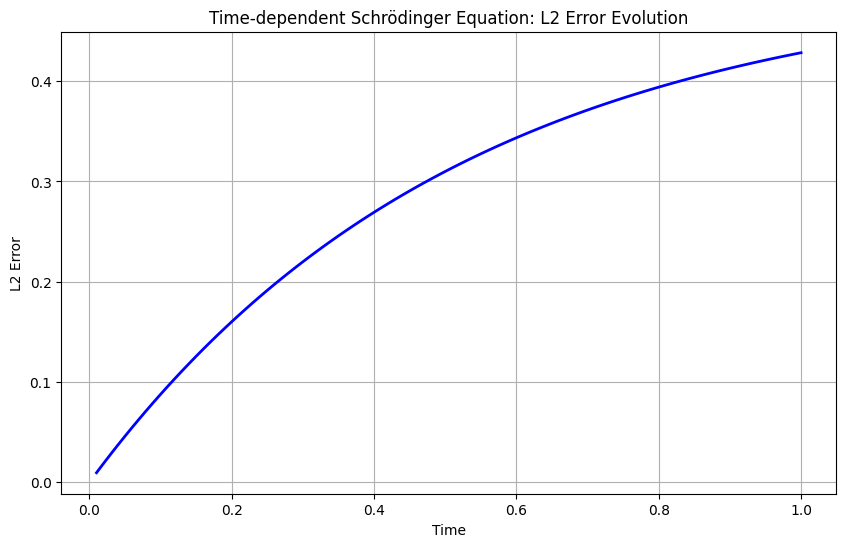

In [274]:
# Plot error evolution
plt.figure(figsize=(10, 6))
plt.plot(times, l2_errors, 'b-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('L2 Error')
plt.title('Time-dependent Schrödinger Equation: L2 Error Evolution')
plt.grid(True)
plt.savefig('schroedinger_error.png', dpi=150, bbox_inches='tight')
plt.show()

In [275]:
# Compare final solution with exact solution
t_final = T
u_exact_final = dolfinx.fem.Function(V, dtype=np.complex128)
u_exact_final.interpolate(lambda x: exact_solution(x, t_final))

In [276]:
print(f"\nFinal time t={t_final}")
print(f"Max error (real part): {np.max(np.abs(u_n1.x.array.real - u_exact_final.x.array.real)):.2e}")
print(f"Max error (imag part): {np.max(np.abs(u_n1.x.array.imag - u_exact_final.x.array.imag)):.2e}")


Final time t=1.0
Max error (real part): 3.33e-01
Max error (imag part): 5.87e-01



Creating visualization...


error: XDG_RUNTIME_DIR is invalid or not set in the environment.
error: XDG_RUNTIME_DIR is invalid or not set in the environment.


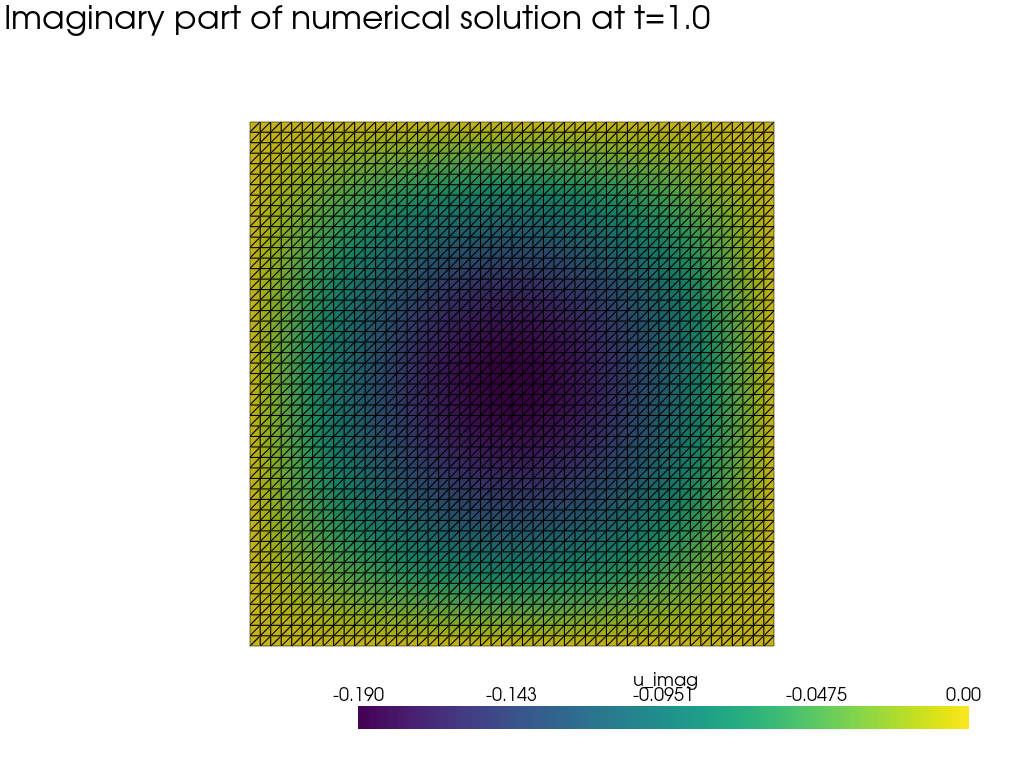

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


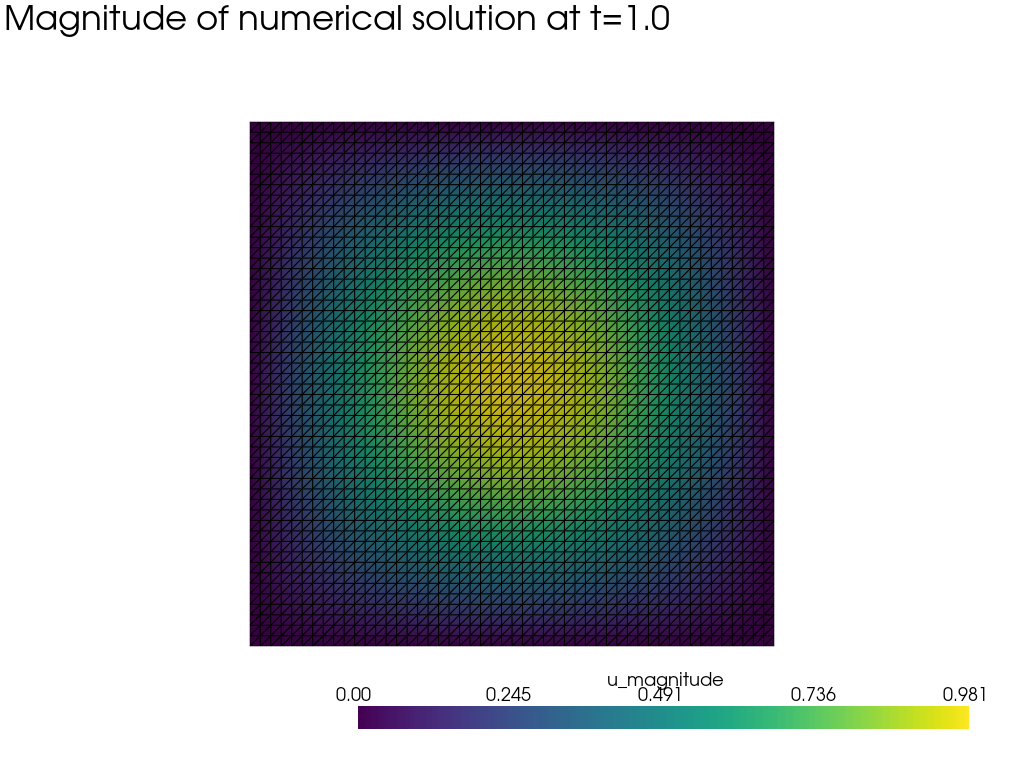

Visualization completed successfully


In [277]:
# Visualization using PyVista
if MPI.COMM_WORLD.rank == 0:
    print("\nCreating visualization...")
    
    try:
        pyvista.start_xvfb()
        
        # Create PyVista mesh
        mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
        pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V)
        grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
        
        # Add solution data
        grid.point_data["u_real"] = u_n1.x.array.real
        grid.point_data["u_imag"] = u_n1.x.array.imag
        grid.point_data["u_magnitude"] = np.abs(u_n1.x.array)
        
        # Add exact solution data
        grid.point_data["u_exact_real"] = u_exact_final.x.array.real
        grid.point_data["u_exact_imag"] = u_exact_final.x.array.imag
        grid.point_data["u_exact_magnitude"] = np.abs(u_exact_final.x.array)
        
        # Plot real part of numerical solution
        grid.set_active_scalars("u_real")
        p_real = pyvista.Plotter()
        p_real.add_mesh(grid, show_edges=True)
        p_real.view_xy()
        p_real.add_text(f"Real part of numerical solution at t={t_final}", position='upper_left')
        if not pyvista.OFF_SCREEN:
            p_real.show(jupyter_backend='none')
            figure = p_real.screenshot("schroedinger_real.png")
        
        # Plot imaginary part of numerical solution
        grid.set_active_scalars("u_imag")
        p_imag = pyvista.Plotter()
        p_imag.add_mesh(grid, show_edges=True)
        p_imag.view_xy()
        p_imag.add_text(f"Imaginary part of numerical solution at t={t_final}", position='upper_left')
        if not pyvista.OFF_SCREEN:
            p_imag.show()
            figure = p_imag.screenshot("schroedinger_imag.png")
        
        # Plot magnitude
        grid.set_active_scalars("u_magnitude")
        p_mag = pyvista.Plotter()
        p_mag.add_mesh(grid, show_edges=True)
        p_mag.view_xy()
        p_mag.add_text(f"Magnitude of numerical solution at t={t_final}", position='upper_left')
        if not pyvista.OFF_SCREEN:
            p_mag.show()
            figure = p_mag.screenshot("schroedinger_mag.png")
        print("Visualization completed successfully")
        
    except Exception as e:
        print(f"Visualization error: {e}")
        print("This is normal in containerized environments")
